Bayesian Inference using DiffEqBayes.jl, from https://docs.sciml.ai/SciMLTutorialsOutput/html/model_inference/01-pendulum_bayesian_inference.html  (By Vaibhav Dixit)
Note it gives warnings about CMDSTAN_HOME,  but it seems to work anyway.  I have cmdstan installed but it is in a conda environment.

In [33]:
using DiffEqBayes, OrdinaryDiffEq, RecursiveArrayTools, Distributions, Plots, StatsPlots, BenchmarkTools, TransformVariables, LinearAlgebra


In [4]:
using Suppressor


In [5]:
function pendulum(du,u,p,t)
    ω,L = p
    x,y = u
    du[1] = y
    du[2] = - ω*y -(9.8/L)*sin(x)
end

u0 = [1.0,0.1]
tspan = (0.0,10.0)
prob1 = ODEProblem(pendulum,u0,tspan,[1.0,2.5])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 0.1

Note `u[1]` is the position

In [6]:
sol = solve(prob1,Tsit5())
plot(sol)

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\rjljr\.julia\packages\SciMLBase\QqtZA\src\retcodes.jl:355


Create fake data


In [70]:
t = collect(range(1,stop=10,length=10))
randomized = VectorOfArray([(sol(t[i]) + .05randn(2)) for i in 1:length(t)])
data = convert(Array,randomized)

2×10 Matrix{Float64}:
  0.0471067  -0.408465  0.103897  …   0.0226154  0.078096   0.0139487
 -1.1591      0.397875  0.25565      -0.136114   0.0369185  0.0125811

In [71]:
scatter!(data')

In [72]:
priors = [Uniform(0.1,3.0), Normal(3.0,1.0)]

bayesian_result = @suppress begin
                       turing_inference(prob1,Tsit5(),t,data,priors;num_samples=10_000,
                                   syms = [:omega,:L])
                  end

Chains MCMC chain (10000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 16.47 seconds
Compute duration  = 16.47 seconds
parameters        = omega, L, σ[1]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       omega    1.1115    0.2645     0.0026    0.0041   4256.9208    0.9999    ⋯
           L    2.4557    0.2418     0.0024    0.0037   4497.3954    1.0001    ⋯
        σ[1]    0.1810    0.0404     0.0004    0.0006   3976.5568    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0% 

In [73]:
plot(bayesian_result)

Using Turing directly: https://turinglang.org/dev/tutorials/10-bayesian-differential-equations/

In [22]:
using Turing

In [74]:
@model function fit_pend(data, prob)
    # Prior distributions.
    omega ~ Uniform(0.1, 3.0)
    L  ~ Normal(3.0, 1.0)
    σ  ~ Exponential(1)
 

    # Simulate pendulum. 
    p = [omega, L]
    predicted = solve(prob1, Tsit5(); p=p, saveat=t)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

fit_pend (generic function with 2 methods)

In [75]:
model = fit_pend(data, prob1)

DynamicPPL.Model{typeof(fit_pend), (:data, :prob), (), (), Tuple{Matrix{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(pendulum), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fit_pend, (data = [0.04710668692240057 -0.4084646688797254 … 0.07809595963858337 0.013948707310017312; -1.1591031972064834 0.3978751746799367 … 0.03691851761595424 0.012581111598038425], prob = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(pendulum), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, No

In [78]:
chain = @suppress  begin sample(model, NUTS(1000,0.5), MCMCSerial(), 1000,3) end

Chains MCMC chain (1000×15×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 3.43 seconds
Compute duration  = 3.42 seconds
parameters        = omega, L, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       omega    1.0099    0.0721     0.0013    0.0017   1411.7353    1.0001    ⋯
           L    2.4567    0.0788     0.0014    0.0021   1339.7817    1.0013    ⋯
           σ    0.0660    0.0123     0.0002    0.0004   1301.2617    1.0009    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0

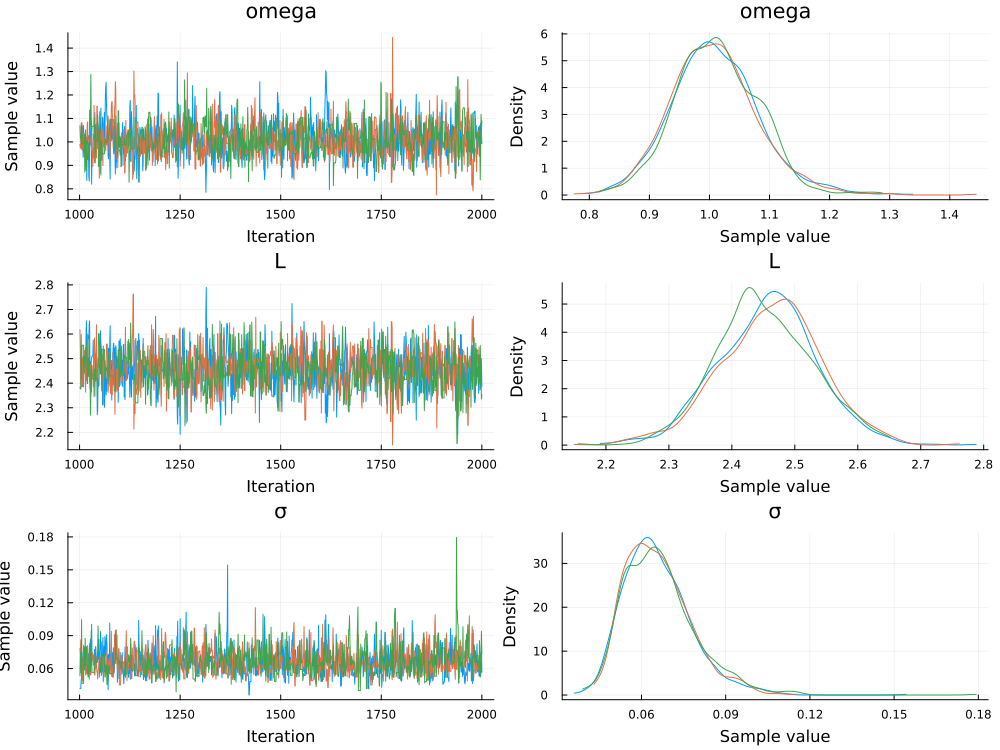

In [79]:
plot(chain)

With only position measurements:

In [82]:
@model function fit_pend_2(data, prob)
    # Prior distributions.
    omega ~ Uniform(0.1, 3.0)
    L  ~ Normal(3.0, 1.0)
    σ  ~ Exponential(1)
 

    # Simulate pendulum. 
    p = [omega, L]
    predicted = solve(prob1, Tsit5(); p=p, saveat=t, save_idxs=1)

    # Observations.
    for i in 1:length(predicted)
        data[1, i] ~ Normal(predicted[i], σ^2)
    end

    return nothing
end

model2 = fit_pend_2(data, prob1)

# note the target acceptance was changed as well as adaptation stems 
chain2 = @suppress  begin sample(model2, NUTS(2000, 0.5), MCMCSerial(), 1000,3) end

Chains MCMC chain (1000×15×3 Array{Float64, 3}):

Iterations        = 2001:1:3000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 5.21 seconds
Compute duration  = 5.18 seconds
parameters        = omega, L, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       omega    1.0883    0.1384     0.0025    0.0032   1378.5016    1.0019    ⋯
           L    2.3778    0.1516     0.0028    0.0037   1419.0923    1.0018    ⋯
           σ    0.2387    0.0327     0.0006    0.0009   1047.4132    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0

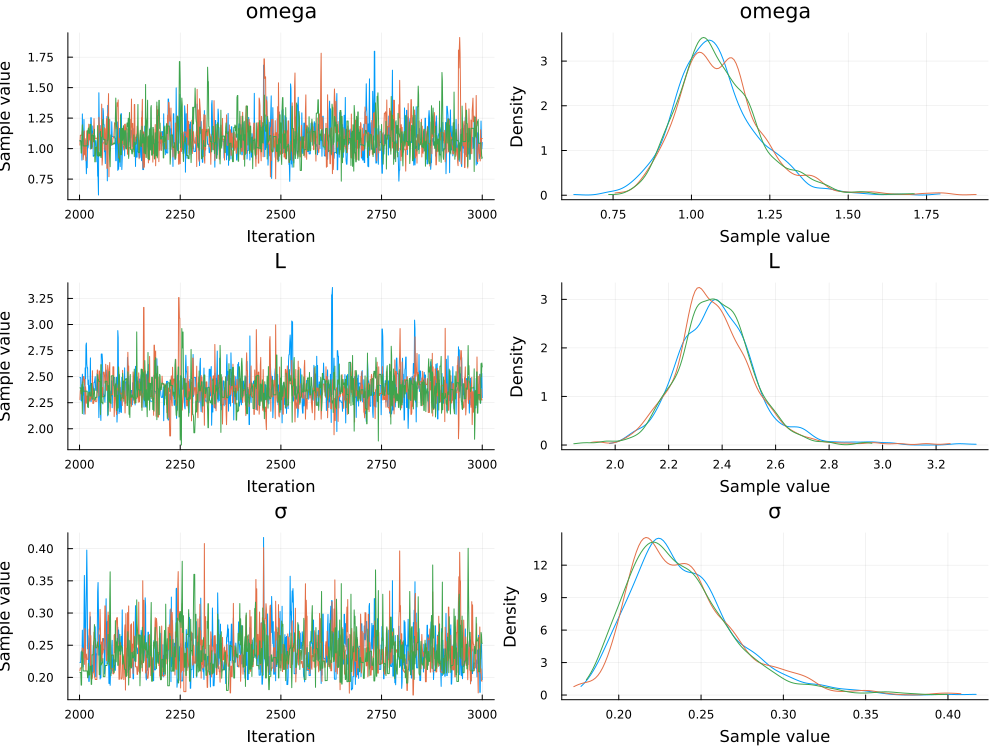

In [83]:
plot(chain2)

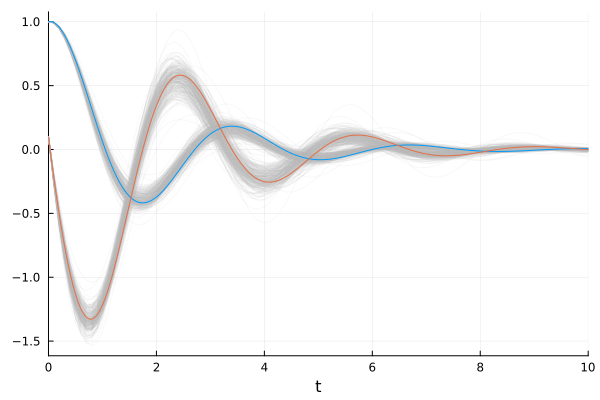

In [84]:
plot(; legend=false)
posterior_samples = sample(chain2[[:omega, :L, :σ]], 300; replace=false)
for p in eachrow(Array(posterior_samples))
    sol_p = solve(prob1, Tsit5(); p=p, saveat=.1)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
plot!(sol; color=[1 2], linewidth=1)
#scatter!(sol.t, odedata'; color=[1 2])